In [1]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [2]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6


In [3]:
# rainbowcloud theme for plotting, stolen from: 
# https://micahallen.org/2018/03/15/introducing-raincloud-plots/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com
raincloud_theme = theme(
text = element_text(size = 10),
axis.title.x = element_text(size = 16),
axis.title.y = element_text(size = 16),
axis.text = element_text(size = 14),
axis.text.x = element_text(angle = 45, vjust = 0.5),
legend.title=element_text(size=16),
legend.text=element_text(size=16),
legend.position = "right",
plot.title = element_text(lineheight=.8, face="bold", size = 16),
panel.border = element_blank(),
panel.grid.minor = element_blank(),
panel.grid.major = element_blank(),
axis.line.x = element_line(colour = 'black', size=0.5, linetype='solid'),
axis.line.y = element_line(colour = 'black', size=0.5, linetype='solid'))

In [4]:
# stealing ability to make flat violin plots
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")

### Functions we're going to use to do the analysis later

#### Miscellaneous

In [5]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Foveal'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Foveal'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Foveal')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Foveal'){
        return(-1)
    } else {
        return(1)
    }
}

#### Dissimilarity Matrices

In [6]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [7]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = p_confidence)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [8]:
# making a matrix symmetric. Stolen from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-
function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not sqare matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

#### Multidimensional Scaling Plots

In [9]:
# turn a dataset into a matrix
df2mat <- function(datadf,eccentricity1,eccentricity2,dependent='color'){
    
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datadf = subset(datadf, Circle_1 == eccentricity1)
    datadf = subset(datadf, Circle_2 == eccentricity2)
    
    if(dependent == 'position'){ # using stimulus location as a negative control
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$bin1, datadf$bin2),FUN=mean)
        nmdsdata$bin1 <- nmdsdata$Group.1
        nmdsdata$bin2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("bin1","bin2","p_confidence"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, bin1, p_confidence)
    } else { # color as per normal
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
        nmdsdata$Color_1 <- nmdsdata$Group.1
        nmdsdata$Color_2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","p_confidence"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, Color_1, p_confidence)
    }
    
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    
    # having 0 dissimilarity between identical objects messes up the algorithm
    # changing the 0 values to an arbitrarily small value, but this is not a good long-term solution
    # need to find a better way of doing this
    nmdsmatrix[nmdsmatrix == 0] <- 0.01
    
    
    nmdsmatrix <- make.symmetric(nmdsmatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    return(nmdsmatrix)
}

In [10]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Non-metric multidimensional scaling (NMDS)

In [11]:
# find the nmds fit for a dataset
nmdsfit <- function(distmatrix){
      
    fit <- isoMDS(distmatrix,k=2, maxit=100)
    return(fit)
}

In [12]:
# plot the nmds fit
nmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = points.1, y = points.2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Non-metric MDS',sep=' - '))
    return(plot)
}

Classical multidimensional scaling

In [13]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [14]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [15]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = p_confidence)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency')
    return(plot)
}

simhistplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = p_confidence)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') 
    return(plot)
    
}

In [16]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= p_confidence, y=response_time)) + 
    stat_summary(fun.y = mean, geom = "bar") + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    
    plot <- ggplot(datadf, aes(x= p_confidence, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [17]:
# reaction time raincloud plot
rsplot_raincloud <- function(datadf,xtype='linear'){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    datadf$p_confidence <- as.character(datadf$p_confidence) # necessary for visualisation
    
    ylabtext = 'Reaction Time (ms)'
    
    plot <- ggplot(datadf, aes(y = response_time, x = p_confidence, fill = p_confidence)) +
            geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8) +
            geom_point(aes(y = response_time, color = p_confidence),
                   position = position_jitter(width = .15), size = .5, alpha = 0.8) +
            geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, alpha = 0.5) +
            expand_limits(x = 5.25) +
            guides(fill = FALSE) +
            guides(color = FALSE) +
            scale_color_brewer(palette = "Spectral") +
            scale_fill_brewer(palette = "Spectral") +
            xlab('Dissimilarity') + ylab("Reaction Time (ms)")
            # coord_flip() +
            theme_bw() +
            raincloud_theme
    
    if(xtype == 'log'){
        plot <- plot + scale_y_continuous(trans='log10')
    } else{
        plot <- plot + ylim(0,5000)
    }
    
    return(plot)
}

In [18]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

### Statistics

Setting parameters

In [19]:
acceptable_trace = 2
acceptable_antitrace = 4

Useful functions

In [20]:
# compare the foveal and peripheral matrices to each other
fvp_test <- function(datadf,dependent='color'){
    
    if(dependent=='position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else{
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    #Fovea vs Periphery
    test <- mantel(fmatrix, pmatrix, method="spearman",permutations = 9999)
    return(test)
}

In [21]:
# compare the each of the foveal and peripheral matrices to a random uniform distribution using a ... test
# not actually sure this is conceptually possible or even makes sense
rand_test <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    # compare
    ftest <- 
    ptest <- 
    return(list("ftest" = ftest, "ptest" = ptest)) # use index of result to get the foveal or peripheral comparison
}



In [22]:
# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...

trace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    
    return(list( (sum(diag(fmatrix))/nrow(fmatrix)), (sum(diag(pmatrix))/nrow(pmatrix))))
}

In [23]:
# find the 'anti-trace' of a matrix
antitrace <- function(mat){
    
    sum = 0
    for(i in (1:nrow(mat))){
        k = mat[ i, as.integer((ncol(mat)/2+i) %% ncol(mat))+1 ]
        sum = sum + k
    }
    return(sum/nrow(mat))
}

In [24]:
# calculates the average of the 'anti-trace', the values I'd expect to be the most dissimilar.
# this may not be an appropriate imposition on subjects...

antitrace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    return(list(antitrace(fmatrix), antitrace(pmatrix)))
}

In [25]:
# just get a simple measure of if the matrices are correlated, irrespective of treating them as distance matrices
matrixcor <- function(datadf,dependent='color'){
    
    if(dependent == 'position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else {
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    
    return(cor(c(fmatrix), c(pmatrix), method = "spearman"))
}

Run the analysis

In [26]:
# stats for all the subjects
allsubjectstats <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects


    for (subjectid in subjectlist){
        
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        cat("SUBJECT: ",subjectid,'\n') # print subject id
        print("Mantel Test: ")
        print(fvp_test(subjectdf))
        print("Matrices correlation: ")
        print(matrixcor(subjectdf))
        print("Quality control measures:")
        print("Trace average:")
        print(trace_avg(subjectdf))
        print("Anti-trace average:")
        print(antitrace_avg(subjectdf))
    }
}

In [27]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [28]:
# compliance checker
compliance_checker <- function(datadf,eccentricity){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    n_subject = length(subjectlist)
    trace_fail = 0
    antitrace_fail = 0
    
    if(eccentricity == 'Foveal'){
        e_ind = 1
    } else if (eccentricity == 'Peripheral'){
        e_ind = 2
    }

    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        if(trace_avg(subjectdf)[e_ind] > acceptable_trace){
            trace_fail = trace_fail + 1
        }
        if(antitrace_avg(subjectdf)[e_ind] < acceptable_antitrace){
            antitrace_fail = antitrace_fail + 1
        }
    }
    print(paste("Trace non-compliance: ",trace_fail,"/",n_subject))
    print(paste("Anti-trace non-compliance: ",antitrace_fail,"/",n_subject))
}

In [29]:
# summary stats
summarystats <- function(datadf,dependent='color'){
    if(dependent=='position'){
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf),'position'))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf),'position'))
    } else {
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf)))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf)))
    }
    
    
    print("Foveal compliance:")
    compliance_checker(datadf,'Foveal')
    print("Peripheral compliance:")
    compliance_checker(datadf,'Peripheral')
}

## Actual Data Analysis Time

### Plot individual subjects

#### Initial data pre-processing, before getting to the subject level

In [30]:
# Initial data of 15 subjects from mTurk
filename = "4stimaftersingle.csv"
datadf = read.csv(filename)
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later

In [31]:
# remove practice trial data
datadf <- subset(datadf, trial_number != 0)

In [32]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))

# colors for the labels
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9','#00A9FF','#0000FF','#AA00FF','#FF00AA')
abcolors <- sort(colors)

In [33]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
foveal = -1
peripheral = 1

In [34]:
# set the maximum and minimum dissimilarity values for later analysis
min_val = 0
max_val = 6

In [35]:
# set the number of trials subjects do
trialnumber = 243

In [36]:
# binning the positions the stimuli were displayed in to use as a control measure later
datadf$bin1 <- as.integer((datadf$Position_1+180) / 40) + 1
datadf$bin2 <- as.integer((datadf$Position_2+180) / 40) + 1

Some actual data cleaning

In [37]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,trialnumber){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        if ( nrow(subset(datadf, subject == ID)) != trialnumber){ # see if they have all 243 trials
            print(paste("Subject",ID,"did not complete the task",sep=' '))
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [38]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,trialnumber)

[1] "Subject 814700919 did not complete the task"


In [39]:
# function to list participants who don't meet statistical cleaning assumptions


#### Actually plot the individual subjects

In [40]:
# plot summary data for all the subjects individually
allsubjectsplot <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects

    dir.create(paste(savestr,"Subject_Plots",sep='_')) # make a new folder to store the subject plots in

    for (subjectid in subjectlist){
        print(paste("Processing subject:",subjectid,sep=' '))
        subjectplot(datadf, subjectid)
    }
}

In [41]:
# make a plot of the key summary data for a subject
subjectplot <- function(datadf, subjectid){
    
    subjectdf = subset(datadf, subject == subjectid) # select the ID for subject of interest
    
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(subjectdf, abcolors, l2e('Foveal'), l2e('Foveal')),colors)
    
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(subjectdf, abcolors, l2e('Peripheral'), l2e('Peripheral')),colors)
    
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
    
    # FF CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    
    # FF CMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
    
    # FF CMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    
    # Similarity judgements
    simplot <- simhistplot(subjectdf)
    # Reaction times
    reactionplot <- rsplot(subjectdf)
    # summary plot
    rainplot <- rsplot_raincloud(subjectdf,'log')
    
    # put all the plots together
    g <- arrangeGrob(FFmatrix,  PPmatrix, simplot,
                    FFcmds,PPcmds, reactionplot,
                    FFnmds,PPnmds, rainplot,
                    nrow = 3, ncol=3)
    
    # save it
    ggsave(paste(savestr,"Subject_Plots/","ID",subjectid,"plot.png",sep='_'),g, height = 30, width = 40)
}

In [42]:
# should add a function to make the subject summary plot clearly label non-compliant subjects, 
# e.g. turn the background red or something

In [43]:
allsubjectsplot(datadf)

[1] "Processing subject: 2989630"
initial  value 24.401112 
iter   5 value 18.876591
iter  10 value 18.504466
iter  10 value 18.494426
iter  10 value 18.487767
final  value 18.487767 
converged
initial  value 29.438003 
iter   5 value 22.567421
iter  10 value 17.712165
iter  15 value 17.019355
final  value 16.987386 
converged
[1] "Processing subject: 43104521"
initial  value 7.097545 
iter   5 value 4.083738
iter  10 value 3.914152
final  value 3.865326 
converged
initial  value 7.708246 
iter   5 value 4.617160
iter  10 value 4.431503
final  value 4.423670 
converged
[1] "Processing subject: 56511823"
initial  value 22.595366 
iter   5 value 20.100824
iter  10 value 18.326188
final  value 18.206941 
converged
initial  value 24.679758 
final  value 18.717436 
converged
[1] "Processing subject: 69616059"
initial  value 19.784113 
iter   5 value 13.807466
final  value 13.715258 
converged
initial  value 21.668742 
iter   5 value 17.416482
iter  10 value 15.076038
final  value 14.883531 

### Plot summary of all subjects

In [44]:
# generate a summary plot of all the collected data from all the subjects
subjectsummaryplot <- function(datadf){
    
    # MATRICES
    everyonedata <- aggregate_df(datadf)
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, abcolors, l2e('Foveal'), l2e('Foveal')),colors)
    
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, abcolors, l2e('Peripheral'), l2e('Peripheral')),colors)
    
    # CMDS
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
    
    # FF CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    # NMDS
    # FF nMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
   
    # FF CMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    
    # AUXILIARY plots
    # Similarity judgements
    simplot <- simhistplot_summary(datadf)
    # Reaction times v1
    reactionplot <- rsplot_summary(datadf)
    # summary plot
    raincloudplot <- rsplot_raincloud(datadf,'log')
    
    # put it all together
    g <- arrangeGrob(FFmatrix,  PPmatrix, simplot,
                    FFcmds,PPcmds, reactionplot,
                    FFnmds,PPnmds, raincloudplot,
                    nrow = 3, ncol=3)
    
    # save it
    ggsave(paste(savestr,"Summary","plot.png",sep='_'),g, height = 30, width = 30)
}

In [45]:
subjectsummaryplot(datadf)

initial  value 18.045147 
iter   5 value 13.613919
iter  10 value 12.711236
final  value 12.591754 
converged
initial  value 20.278080 
iter   5 value 15.905147
iter  10 value 15.444714
iter  10 value 15.444568
iter  10 value 15.444568
final  value 15.444568 
converged


In [46]:
# position plot (negative control)
positionplot <- function(datadf){
    # MATRICES
    everyonedata <- aggregate_df(datadf)
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors, 'position')
    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors, 'position')
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors, 'position')
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix,
                    nrow = 1, ncol= 3)
     # save it
    ggsave(paste(savestr,"position negative control","plot.png",sep='_'),g, height = 10, width = 30)
}

In [47]:
summarystats(datadf)

[1] "Mantel Test: "

Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = fmatrix, ydis = pmatrix, method = "spearman", permutations = 9999) 

Mantel statistic r: 0.4301 
      Significance: 0.0067 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.232 0.293 0.347 0.415 
Permutation: free
Number of permutations: 9999

[1] "Matrices correlation: "
[1] 0.5708573
[1] "Foveal compliance:"
[1] "Trace non-compliance:  7 / 13"
[1] "Anti-trace non-compliance:  6 / 13"
[1] "Peripheral compliance:"
[1] "Trace non-compliance:  9 / 13"
[1] "Anti-trace non-compliance:  7 / 13"


### Playing with Analysis Techniques

In [48]:
# return a list of the fovea matrix vs periphery matrix correlations for each subject

fvp_list <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
        correlation_list <- c(correlation_list,matrixcor(subjectdf))
    }
    return(correlation_list)
}

In [49]:
fvp_correlations <- data.frame(fvp_list(datadf))

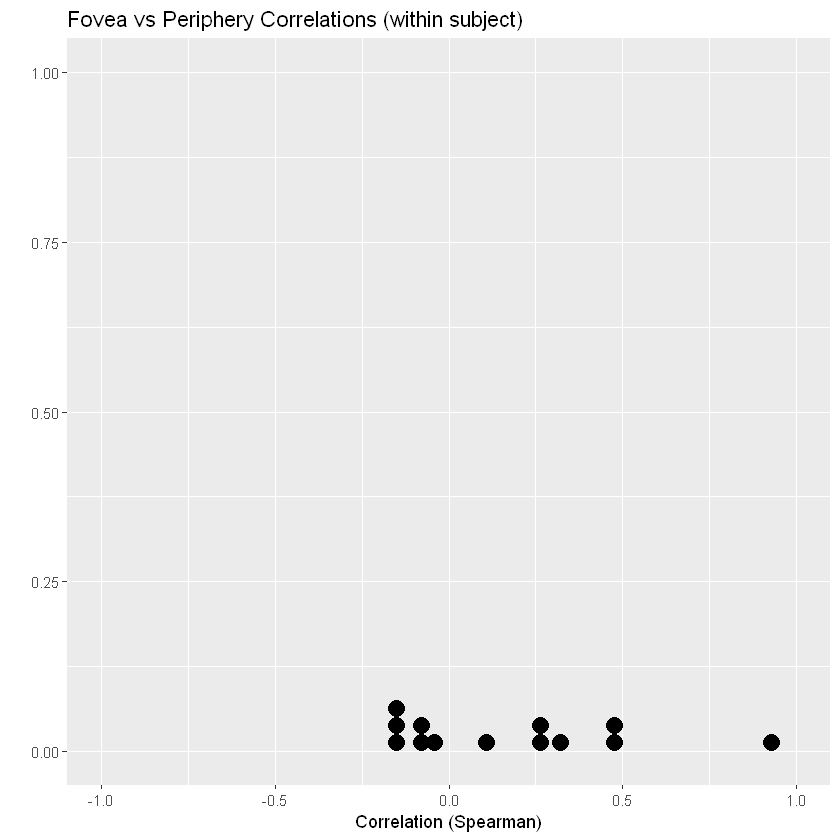

In [50]:
# plot the correlation list
# should this be r-to-z transformed?
corr_plot_1 <- ggplot(fvp_correlations,aes(x=fvp_list.datadf.)) + 
                geom_dotplot(binwidth=0.05) + 
                xlim(-1,1) + xlab('Correlation (Spearman)') + ylab('') + ggtitle('Fovea vs Periphery Correlations (within subject)')
corr_plot_1

In [51]:
# return a list of the fovea matrix (i) vs fovea matrix (j) correlations for all subjects
fi_v_fj_list <- function(datadf,samples){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (i in 1:samples){ # go through subject by subject
        i_j <- sample(subjectlist, 2, replace = FALSE)
        subjectdf_i = subset(datadf, subject == i_j[1])
        subjectdf_j = subset(datadf, subject == i_j[2])
        
        fmatrix_i <- df2mat(subjectdf_i, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix
        fmatrix_j <- df2mat(subjectdf_j, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix
        
        correlation_list <- c(correlation_list, cor(c(fmatrix_i), c(fmatrix_j), method = "spearman"))
    }
    return(data.frame(correlation_list))
}

In [52]:
fcor <- fi_v_fj_list(datadf,100)


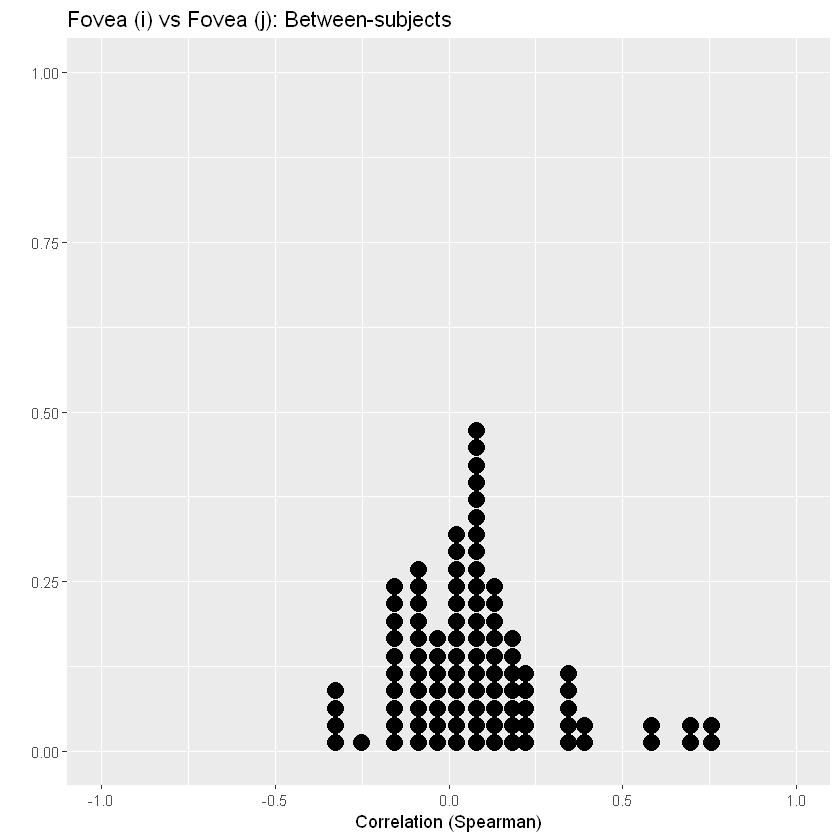

In [53]:
corr_plot_2 <- ggplot(fcor,aes(x=correlation_list)) + 
                geom_dotplot(binwidth=0.05) + 
                xlim(-1,1) + xlab('Correlation (Spearman)') + ylab('') + ggtitle('Fovea (i) vs Fovea (j): Between-subjects')
corr_plot_2

In [54]:
# put it all together
    g <- arrangeGrob(corr_plot_1,corr_plot_2,
                    nrow = 1, ncol= 2)
    
    # save it
    ggsave(paste(savestr,"correlation plot comparisons","plot.png",sep='_'),g, height = 5, width = 10)

In [55]:
id <- c(1:15)
collated <- data.frame(id,fvp_list(datadf),fi_v_fj_list(datadf,15))


ERROR: Error in data.frame(id, fvp_list(datadf), fi_v_fj_list(datadf, 15)): arguments imply differing number of rows: 15, 13


In [ ]:
names(collated)[2] <- "within_subject"
names(collated)[3] <- "between_subject - random samples"

In [ ]:
collated

In [ ]:
collated_melted <- melt(collated, id = c("id","within_subject","between_subject - random samples"))
collated_reshaped <- reshape(collated, direction = "long",timevar="within_between",
                             varying = list(names(collated)[2:3]), v.names = "Value")

In [ ]:
collated_reshaped

In [ ]:
collated_reshaped$within_between[collated_reshaped$within_between == 1] ='within_subject - Fi v Fi'
collated_reshaped$within_between[collated_reshaped$within_between == 2] ='between_subject - Fi v Fj'

In [ ]:
collated_reshaped

In [ ]:
collated_plot <- ggplot(collated_reshaped, aes(x=within_between, y=Value)) + geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                ylab("Correlation (Spearman)") + xlab("") + ylim(-1,1) +
                theme(text = element_text(size=20))
collated_plot